In [2]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import ticker
import os
import io
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import requests
# import babel.numbers
# import decimal
#import locale
#locale.setlocale( locale.LC_ALL, '' )


from User_input import st_file_selector, Prior_probability_binary, make_value_array
from Naive_Bayes import make_train_test, optimal_bin
from Bayesian_Modeling import likelihood_KDE, Scaledlikelihood_KDE, Posterior_by_hand, Posterior_Marginal_plot, marginal, Posterior_via_NaiveBayes
from VOI import Vperfect, f_MI, f_VIMPERFECT, f_VPRIOR

# Loading Files and Features

In [3]:
url = 'https://github.com/wtrainor/INGENIOUS_streamlit/raw/main/File Template/POS_COMBINED_NEW_JULYRESID_INGENIOUS_updated.csv'
pos_file = requests.get(url).content


url = 'https://github.com/wtrainor/INGENIOUS_streamlit/raw/main/File Template/NEG_COMBINED_NEW_JULYRESID_INGENIOUS_updated.csv'
neg_file = requests.get(url).content
# Positive file if user chooses to upload should have PosSite_Distance (distance to positive sites)
# Negative file if user chooses to upload should have NegSite_Distance (distance to negative sites)
# Plots (functions) are only for streamlit... use normal methods to plot otherwise.

# Plotting Likelihood and Assigning Inputs

In [4]:
df = pd.read_csv(io.StringIO(pos_file.decode('utf-8')))

dfN = pd.read_csv(io.StringIO(neg_file.decode('utf-8')))
attribute  = df.columns[7] # Randomly choosing one. If the use wishes to choose one manually, change the code here
attribute  = 'cond_mt_mantle_conus117_250m'
df_sc = df[df[attribute]>-9999]
df_scN = dfN[dfN[attribute]>-9999]
dist_met = np.max(df_sc['PosSite_Distance'].quantile(0.1)) # Can change here as well
dist_met = 250

In [22]:
dfpair00 = df_sc[(df_sc['PosSite_Distance'] <=round(dist_met,-1))] 
neg_site_col_name = 'NegSite_Distance'        
dfpair = dfpair00[dfpair00[attribute]>-9999] 
# # # OJO : may want to keep this off until have it for NEG 
dfpairN = df_scN[(df_scN[neg_site_col_name] <=round(dist_met,-1))] 
if np.shape(dfpairN)[0]==0:
    dfpairN = df_scN[(df_scN[neg_site_col_name ] <= np.percentile(df_scN[neg_site_col_name ],10))] 


# Conditional Probability Rough Work

In [122]:
#neg_given_pos = dfpairN[(dfpairN['cond_mt_lowcrust_conus117_250m'] >= dfpair['cond_mt_lowcrust_conus117_250m'].min()) & (dfpairN['cond_mt_lowcrust_conus117_250m'] <= dfpair['cond_mt_lowcrust_conus117_250m'].max())]
neg_given_pos = dfpairN[(dfpairN['cond_mt_mantle_conus117_250m'] >= dfpair['cond_mt_mantle_conus117_250m'].min()) & (dfpairN['cond_mt_mantle_conus117_250m'] <= dfpair['cond_mt_mantle_conus117_250m'].max())]

In [125]:
neg_given_pos.shape[0]/dfpair.shape[0]

0.7889908256880734

In [124]:
#pos_given_neg = dfpair[(dfpair['cond_mt_lowcrust_conus117_250m'] >= dfpairN['cond_mt_lowcrust_conus117_250m'].min()) & (dfpair['cond_mt_lowcrust_conus117_250m'] <= dfpairN['cond_mt_lowcrust_conus117_250m'].max())]
pos_given_neg = dfpair[(dfpair['cond_mt_mantle_conus117_250m'] >= dfpairN['cond_mt_mantle_conus117_250m'].min()) & (dfpair['cond_mt_mantle_conus117_250m'] <= dfpairN['cond_mt_mantle_conus117_250m'].max())]

In [23]:
for i in range (0,a.shape[0]-1):
    if (a[i] == False):
        if (a[i+1] == False):    
            negg1 = (dfpairN[(dfpairN['cond_mt_mantle_conus117_250m'] >= x_sampled[i]) & (dfpairN['cond_mt_mantle_conus117_250m'] <= x_sampled[i+1])])
            poss1 = (dfpair[(dfpair['cond_mt_mantle_conus117_250m'] >= x_sampled[i]) & (dfpair['cond_mt_mantle_conus117_250m'] <= x_sampled[i+1])])
            neg_giv_pos1 = pd.concat([neg_giv_pos1,negg1]) # negative labels when negative
            neg_giv_pos2 = pd.concat([neg_giv_pos2,poss1]) # positive labels when negative
        else:
            continue
    else:
        if(a[i+1] == True):
            negg2 = (dfpairN[(dfpairN['cond_mt_mantle_conus117_250m'] >= x_sampled[i]) & (dfpairN['cond_mt_mantle_conus117_250m'] <= x_sampled[i+1])])
            poss2 = (dfpair[(dfpair['cond_mt_mantle_conus117_250m'] >= x_sampled[i]) & (dfpair['cond_mt_mantle_conus117_250m'] <= x_sampled[i+1])])
            pos_giv_neg1= pd.concat([pos_giv_neg1,poss2]) # positive labels when positive
            pos_giv_neg2 = pd.concat([pos_giv_neg2,negg2]) # negative labels when positive

        else:
            continue

In [27]:
# Test for conditionals....
%matplotlib inline
attribute  = 'cond_mt_lowcrust_conus117_250m'
#X_train, X_test, y_train, y_test = make_train_test(dfpair,attribute,neg_given_pos)
X_train, X_test, y_train, y_test = make_train_test(pos_giv_neg1,attribute,pos_giv_neg2)
 
best_params, accuracy = optimal_bin(X_train, y_train)

# Likelihood via KDE estimate
predictedLikelihood_pos, predictedLikelihood_neg, x_sampled, count_ij= likelihood_KDE(X_train,X_test, y_train, y_test,attribute, best_params)
# Likelihood plot is plotted below

c:\Users\kmenon\Documents\GitHub\INGENIOUS_streamlit\Naive_Bayes.py:66: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X_all = pd.concat((dfpair[x_cur],dfpairN[x_cur]))


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KernelDensity.

2025-04-21 13:51:29.129 
  command:

    streamlit run c:\Users\kmenon\AppData\Local\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


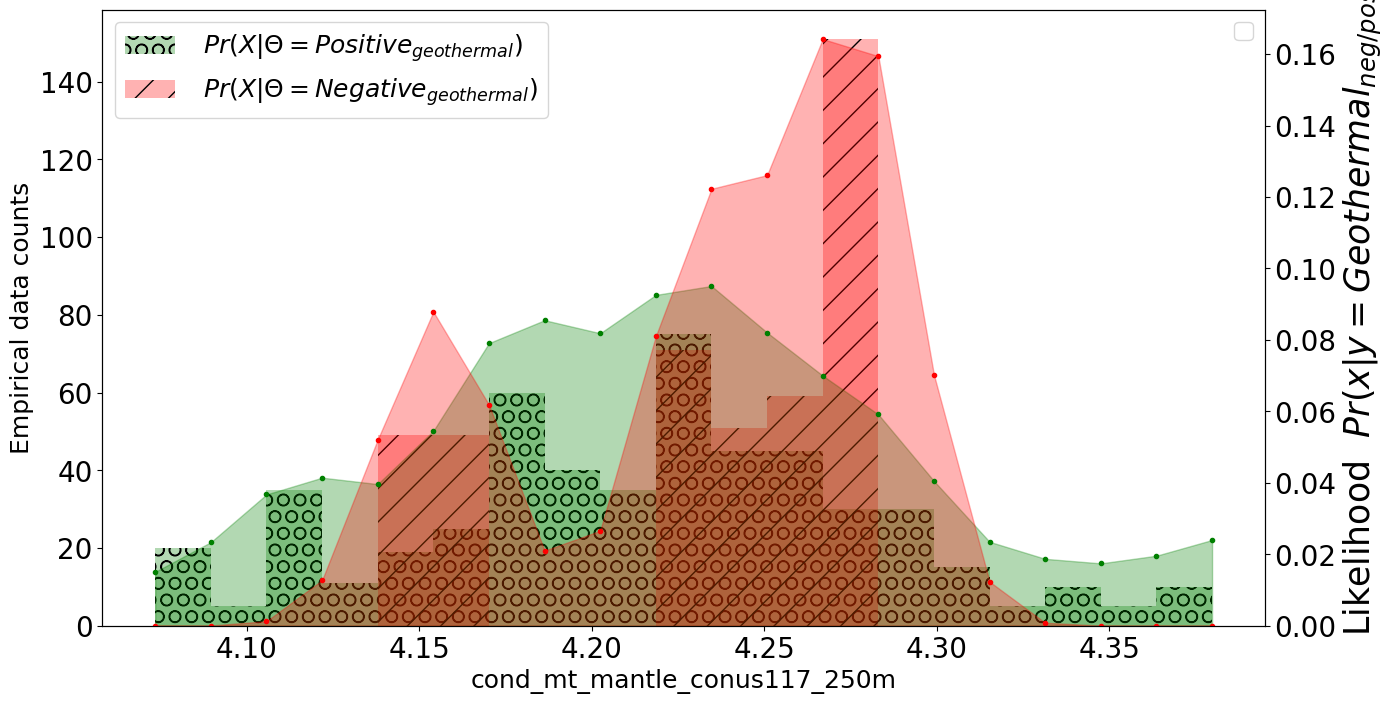

In [6]:
%matplotlib inline
attribute = 'cond_mt_mantle_conus117_250m'
X_train, X_test, y_train, y_test = make_train_test(dfpair,attribute,dfpairN)
#X_train, X_test, y_train, y_test = make_train_test(pos_given_neg,attribute,dfpairN)
best_params, accuracy = optimal_bin(X_train, y_train)

# Likelihood via KDE estimate
predictedLikelihood_pos, predictedLikelihood_neg, x_sampled, count_ij= likelihood_KDE(X_train,X_test, y_train, y_test,attribute, best_params)
# Likelihood plot is plotted below

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\kmenon\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kmenon\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


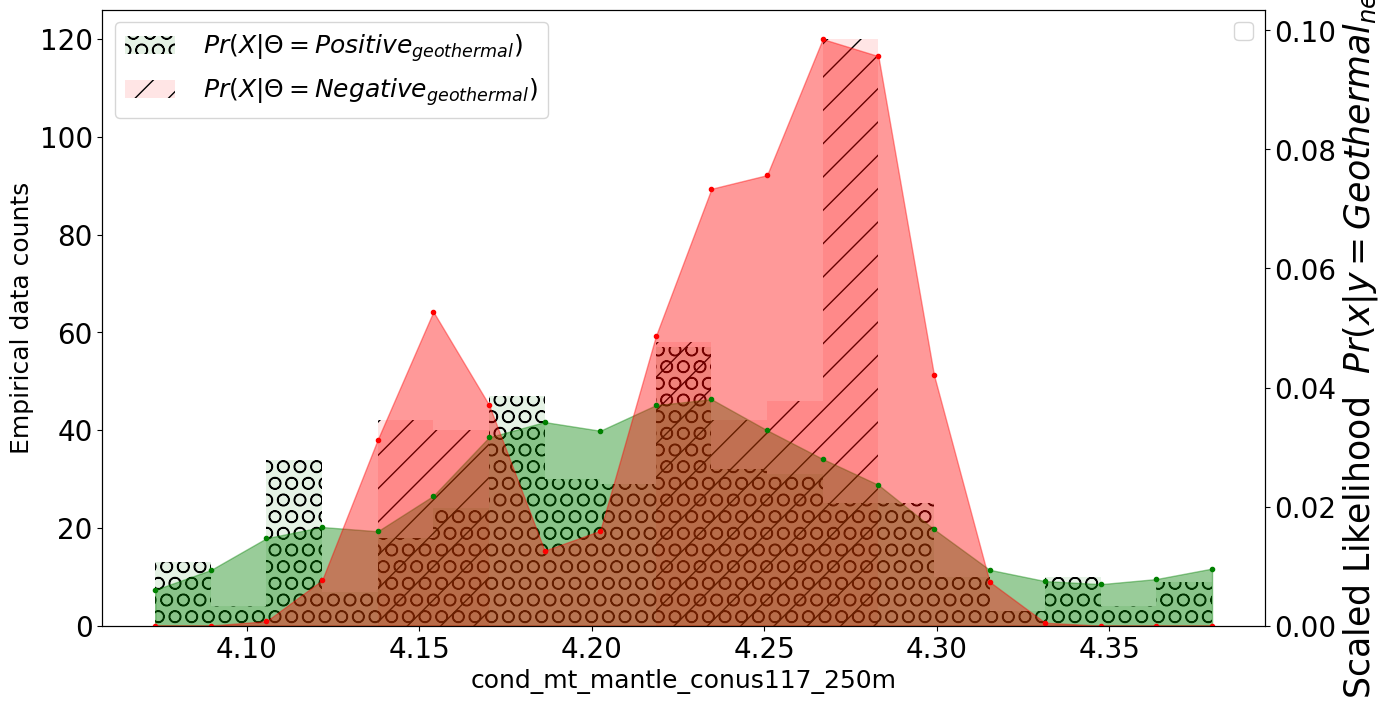

In [8]:
# Scaled Likelihood plots
%matplotlib inline
Pr_prior_POS = 0.4 # Default value
Scaledlikelihood_KDE(Pr_prior_POS,predictedLikelihood_neg, predictedLikelihood_pos,X_train,X_test, y_train, y_test,attribute,x_sampled, best_params)          
# POSTERIOR via_Naive_Bayes: Draw back here the marginal not using scaled likelihood..
post_input, post_uniform = Posterior_via_NaiveBayes(Pr_prior_POS,X_train, X_test, y_train, y_test, x_sampled, attribute)
             
# # DO NOT USEmymodule.marginal( because it's passing unscaled likelihood!!!)
# # Pr_Marg = mymodule.marginal(Pr_prior_POS, predictedLikelihood_pos, predictedLikelihood_neg, x_sampled)
# WAS inputting: post_input, post_uniform, Pr_Marg, x_cur, x_sampled)

2025-04-21 13:51:45.193 Session state does not function when running a script without `streamlit run`


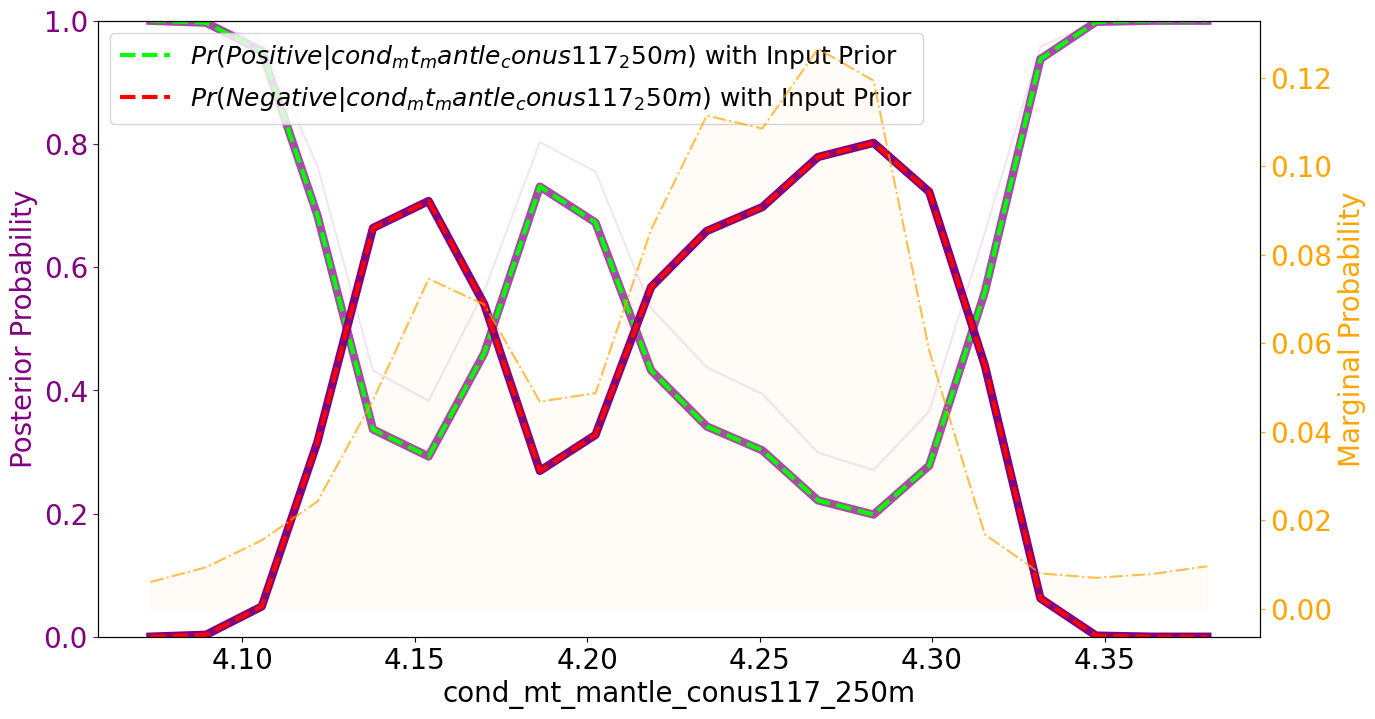

In [9]:
%matplotlib inline
Pr_InputMarg, Pr_UnifMarg, Prm_d_Input, Prm_d_Uniform = Posterior_by_hand(Pr_prior_POS,predictedLikelihood_pos, predictedLikelihood_neg, x_sampled)
Posterior_Marginal_plot(Prm_d_Input, Prm_d_Uniform, Pr_InputMarg, attribute, x_sampled) 

In [117]:
(Prm_d_Input[:,1].mean()*772814)+(Prm_d_Input[:,0].mean()*863506)

807304.6807845405

In [52]:
Prm_d_Input[:,1].mean()

0.6196943414574546

In [29]:
a = (Prm_d_Input[:,1]>Prm_d_Input[:,0])
a

array([ True,  True,  True,  True, False, False, False,  True,  True,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True])

In [28]:
aa = x_sampled[(Prm_d_Input[:,1]>Prm_d_Input[:,0])== True]
aa

array([4.0734158 , 4.08954131, 4.10566682, 4.12179233, 4.18629437,
       4.20241988, 4.31529845, 4.33142396, 4.34754947, 4.36367498,
       4.37980049])

In [38]:
neg_giv_pos1 = pd.DataFrame(columns=dfpairN.columns)
pos_giv_neg1 = pd.DataFrame(columns=dfpair.columns)

neg_giv_pos2 = pd.DataFrame(columns=dfpairN.columns)
pos_giv_neg2 = pd.DataFrame(columns=dfpair.columns)

In [40]:
neg_giv_pos1

,Unnamed: 0,id_rc,row,column,x,y,in_bounds,cond_mt_lowcrust_conus117_250m,cond_mt_mantle_conus117_250m,cond_mt_midcrust_conus117_250m,...,qfaults_dist_age_130k-750k_conus117_250m,qfaults_dist_age_15k-130k_conus117_250m,qfaults_dist_age_750k-2600k_conus117_250m,qfaults_dist_age_other_conus117_250m,qfaults_dist_all_conus117_250m,qfv2_lr_recsr_conus117_250m,tsite_dist_hfqcresid_neg_conus117_250m,PosSite_Distance,NegSite_Distance,geometry


In [41]:
for i in range (0,a.shape[0]-1):
    if (a[i] == False):
        if (a[i+1] == False):    
            negg1 = (dfpairN[(dfpairN['cond_mt_mantle_conus117_250m'] >= x_sampled[i]) & (dfpairN['cond_mt_mantle_conus117_250m'] <= x_sampled[i+1])])
            poss1 = (dfpair[(dfpair['cond_mt_mantle_conus117_250m'] >= x_sampled[i]) & (dfpair['cond_mt_mantle_conus117_250m'] <= x_sampled[i+1])])
            neg_giv_pos1 = pd.concat([neg_giv_pos1,negg1]) # negative labels when negative
            neg_giv_pos2 = pd.concat([neg_giv_pos2,poss1]) # positive labels when negative
        else:
            continue
    else:
        if(a[i+1] == True):
            negg2 = (dfpairN[(dfpairN['cond_mt_mantle_conus117_250m'] >= x_sampled[i]) & (dfpairN['cond_mt_mantle_conus117_250m'] <= x_sampled[i+1])])
            poss2 = (dfpair[(dfpair['cond_mt_mantle_conus117_250m'] >= x_sampled[i]) & (dfpair['cond_mt_mantle_conus117_250m'] <= x_sampled[i+1])])
            pos_giv_neg1= pd.concat([pos_giv_neg1,poss2]) # positive labels when positive
            pos_giv_neg2 = pd.concat([pos_giv_neg2,negg2]) # negative labels when positive

        else:
            continue

C:\Users\kmenon\AppData\Local\Temp\1\ipykernel_36852\1264659844.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_giv_neg1= pd.concat([pos_giv_neg1,poss2]) # positive labels when positive
C:\Users\kmenon\AppData\Local\Temp\1\ipykernel_36852\1264659844.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  neg_giv_pos1 = pd.concat([neg_giv_pos1,negg1]) # negative labels when negative
C:\Users\kmenon\AppData\Local\Temp\1\ipykernel_36852\1264659844.py:7: FutureWarning: The behavior of DataFrame

In [48]:
neg_giv_pos2.shape[0]/dfpairN.shape[0]

0.6255813953488372

In [49]:
pos_giv_neg2.shape[0]/dfpair.shape[0]

0.0

# Value of Information Metrics Calculation

In [198]:
pos_drill_outcome = 1e7
neg_drill_outcome = -1e7
value_array, value_array_df = make_value_array(count_ij, profit_drill_pos= pos_drill_outcome, cost_drill_neg = neg_drill_outcome)

vprior_unif_out = f_VPRIOR([1-Pr_prior_POS,Pr_prior_POS], value_array) #, value_drill_DRYHOLE[-1]       
                       


VPI = Vperfect(Pr_prior_POS, value_array)
        
        
        
VII_input = f_VIMPERFECT(Prm_d_Input, value_array, Pr_InputMarg)
VII_unifPrior = f_VIMPERFECT(Prm_d_Uniform, value_array, Pr_UnifMarg)

In [199]:
print("Prior Value (Vprior) ($): ",vprior_unif_out)
print("Imperfect Value (Vimp) ($): ", VII_input)
print("Value of Imperfect Information ($): ",VII_input-vprior_unif_out)
print("Value of Perfect Information ($): ", VPI-vprior_unif_out)

Prior Value (Vprior) ($):  0.0
Imperfect Value (Vimp) ($):  3433137.5475370763
Value of Imperfect Information ($):  3433137.5475370763
Value of Perfect Information ($):  4000000.0


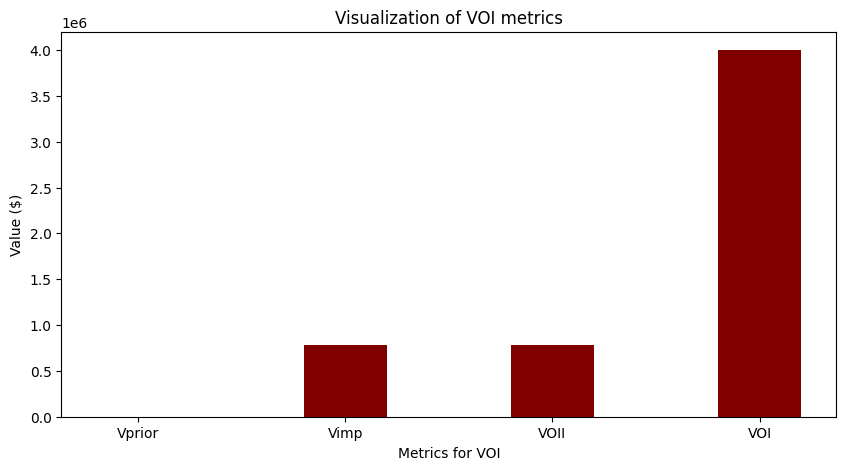

In [24]:
# Bar plot
%matplotlib inline
metric = list[['Vprior', 'Vimp', 'VOII', 'VOI']]
vals = list[vprior_unif_out,VII_input,(VII_input-vprior_unif_out), (VPI-vprior_unif_out)]

data = {'Vprior':vprior_unif_out, 'Vimp':VII_input, 'VOII':(VII_input-vprior_unif_out), 
        'VOI':(VPI-vprior_unif_out)}

metric = list(data.keys())
vals = list(data.values())
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(metric, vals, color ='maroon', 
        width = 0.4)

plt.xlabel("Metrics for VOI")
plt.ylabel("Value ($)")
plt.title("Visualization of VOI metrics")
plt.show()
